# Images for presentation and exam

In [ ]:
import pydicom as dicom
import re
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.util import montage as montage2d


class Patient(object):
    def __init__(self, directory, subdir):
        # deal with any intervening directories
        while True:
            subdirs = next(os.walk(directory))[1]
            if len(subdirs) == 1:
                directory = os.path.join(directory, subdirs[0])
            else:
                break

        slices = []
        for s in subdirs:
            m = re.match("sax_(\d+)", s)
            if m is not None:
                slices.append(int(m.group(1)))

        slices_map = {}
        first = True
        times = []
        for s in slices:
            files = next(os.walk(os.path.join(directory, "sax_%d" % s)))[2]
            offset = None

            for f in files:
                m = re.match("IM-(\d{4,})-(\d{4})\.dcm", f)
                if m is not None:
                    if first:
                        times.append(int(m.group(2)))
                    if offset is None:
                        offset = int(m.group(1))

            first = False
            slices_map[s] = offset

        self.directory = directory
        self.time = sorted(times)
        self.slices = sorted(slices)
        self.slices_map = slices_map
        self.name = subdir

    def _filename(self, s, t):
        fname = os.path.join(self.directory,
                                 "sax_%d" % s, 
                                 "IM-%04d-%04d.dcm" % (self.slices_map[s], t))
        return fname

    def _read_dicom_image(self, filename):
        d = dicom.read_file(filename)
        img = d.pixel_array
        return np.array(img)

    def _read_all_dicom_images(self):
        f1 = self._filename(self.slices[0], self.time[0])
        f2 = self._filename(self.slices[1], self.time[0])
        
        d1 = dicom.read_file(f1)
        d2 = dicom.read_file(f2)
        
        (x, y) = d1.PixelSpacing
        (x, y) = (float(x), float(y))
        self.col_scaling = x
        self.row_scaling = y
        
        # try a couple of things to measure distance between slices
        try:
            dist = np.abs(d2.SliceLocation - d1.SliceLocation)
        except AttributeError:
            try:
                dist = d1.SliceThickness
            except AttributeError:
                dist = 8  # better than nothing...

        # 4D image array
        self.images = np.array([[self._read_dicom_image(self._filename(d, i))
                                for i in self.time]
                                for d in self.slices])
        
        # Distance between slices in mm
        self.dist = dist
        
        # Calculate depth as distance between slices times no. of slices
        self.deph_mm = self.dist * (self.images.shape[0] - 1)
        
        # Area scaling, mm per pixel
        self.area_multiplier = x * y
        
        # Orientation
        self.orientation = d1.ImageOrientationPatient
        
    def load(self):
        self._read_all_dicom_images()

### Load Patient(s)



In [ ]:
def load_patient(patient_id, root_dir=None):
    if not root_dir: 
        root_dir =  os.path.join('..', 'input', 'train', 'train')
    patient_id = str(patient_id)
    base_path = os.path.join(root_dir, patient_id)
    try:
        tdata = Patient(base_path, patient_id)
        tdata.load()
        # If data does not contain 4 dimensions, throw it away
        if len(tdata.images.shape) == 4:
            return tdata
    except (ValueError, TypeError, IndexError, AttributeError, FileNotFoundError):
        print('Patient %s could not be loaded.' % patient_id)
        return None
    
def load_multiple_patients(patient_ids=False, root_dir=None, verbose=False):
    """
    :param patient_ids: ids of patients to load [list of integers]
    :param root_dir: name of root dir, defaults to Kaggle root directory [string]
    :param verbose: Whether to print every patient id when loading [boolean]
    :return: list of [Patient] objects
    """
    # If no ids are specified load all from 1-500
    if not patient_ids:
        patient_ids = range(1, 501)
    patient_list = []
    for pid in patient_ids:
        if verbose:
            print('Loading patient %i...' % pid)
        p_data = load_patient(pid, root_dir=root_dir)
        if p_data:
            patient_list.append(p_data)
    return patient_list

### Plotting functions

In [ ]:
def plot_patient_slices_3d(patient_slices, title=False, figsize=(20,20)):
    '''Plots a 2D image per slice in series (3D in total)'''
    fig, ax = plt.subplots(1,1, figsize=figsize)
    image = montage2d(patient_slices)
    if title: ax.set_title(title)
    ax.imshow(image, cmap = 'bone')
    

def plot_patient_data_4d(patient_data, all_slices=False, slices=[0], figsize=(20,20)):
    '''Plots a 3D image per time step in patient data (4D in total)'''
    if all_slices: 
        slices = range(patient_data.images.shape[0])
    for i in slices: 
        plot_patient_slices_3d(patient_data.images[i], 
                               title=('Showing slice %i' % i))

## Fourier Transform

In [ ]:
import numpy as np

# Based on https://gist.github.com/ajsander/fb2350535c737443c4e0#file-tutorial-md
def fourier_time_transform_slice(image_3d):
    '''
    3D array -> 2D array
    [slice, height, width] -> [height, width]
    Returns (width, height) matrix
    Fourier transform for 3d data (time,height,weight)
    '''
    # Apply FFT to get first harmonic mean
    fft_img_2d = np.fft.fftn(image_3d)[1, :, :]
    return np.abs(np.fft.ifftn(fft_img_2d))

def fourier_time_transform(patient_images):
    '''
    4D array -> 3D array (compresses time dimension)
    Concretely, [slice, time, height, width] -> [slice, height, width]
    Description: Fourier transform for analyzing movement over time.
    '''
    ftt_image = np.array([
        fourier_time_transform_slice(patient_slice)
        for patient_slice in patient_images
    ])
    return ftt_image

> ## Segmentation
* Here, threshold is used for finding a fitting threshhold for segmentation
* We also tried k-means but with less good result
* The image is then segmented using the threshhold, effectively making every pixel either foreground (white = 1) or background (black = 0)
* Lastly, by using an average of segmented pixel intesities, we identify the region of interest

In [ ]:
import numpy as np
import pandas as pd

from skimage.morphology import binary_dilation, binary_erosion, binary_opening, binary_closing, disk
from skimage.filters import threshold_otsu
from sklearn.cluster import KMeans


def kmeans_segmentation(patient_img):
    #Code for kmeans
    xx, yy = np.meshgrid(np.arange(patient_img.shape[1]),np.arange(patient_img.shape[0]))
    patient_df = pd.DataFrame(dict(x=xx.ravel(),y=yy.ravel(),intensity=patient_img.ravel()))

    km = KMeans(n_clusters=2, random_state=2018)

    scale_patient_df = patient_df.copy()
    scale_patient_df.x = scale_patient_df.x/250
    scale_patient_df.y = scale_patient_df.y/250
    scale_patient_df['group'] = km.fit_predict(scale_patient_df[['x', 'y', 'intensity']].values)
    seg_pat_img = scale_patient_df['group'].values.reshape(patient_img.shape)

    return seg_pat_img
    
def thresh_segmentation(patient_img):
    """Returns matrix
    Segmententation of patient_img with threshold
    """
    thresh = threshold_otsu(patient_img)
    binary = patient_img > thresh
    return binary

def segment_multiple(patient_img):
    """Returns list
    List of segmented slices with function thresh_segmentation()
    """
    num_slices, height, width = patient_img.shape
    segmented_slices = np.zeros((num_slices, height, width))

    for i in range(num_slices):
        seg_slice = thresh_segmentation(patient_img[i])
        if seg_slice.sum() > seg_slice.size * 0.5:
            seg_slice = 1 - seg_slice
        segmented_slices[i] = seg_slice

    return segmented_slices

def segment_multiple_kmeans(patient_img):
    """Returns list
    List of segmented slices with function kmeans_segmentation()
    """
    num_slices, height, width = patient_img.shape
    segmented_slices = np.zeros((num_slices, height, width))

    for i in range(num_slices):
        seg_slice = kmeans_segmentation(patient_img[i])
        if seg_slice.sum() > seg_slice.size * 0.5:
            seg_slice = 1 - seg_slice
        segmented_slices[i] = seg_slice

    return segmented_slices

def roi_mean_yx(patient_img):
    """Returns mean(y) and mean(x) [double]
    Mean coordinates in segmented patients slices.
    This function performs erosion to get a better result.
    Original: See https://nbviewer.jupyter.org/github/kmader/Quantitative-Big-Imaging-2019/blob/master/Lectures/06-ShapeAnalysis.ipynb
    """
    
    seg_slices = segment_multiple(patient_img)
    num_slices = patient_img.shape[0]
    y_all, x_all = np.zeros(num_slices), np.zeros(num_slices)
    neighborhood = disk(2)
    
    for i,seg_slice in enumerate(seg_slices):
        # Perform erosion to get rid of wrongly segmented small parts
        seg_slices_eroded = binary_erosion(seg_slice, neighborhood) 
        
        # Filter out background of slice, after erosion [background=0, foreground=1]
        y_coord, x_coord = seg_slices_eroded.nonzero()
        
        # Save mean coordinates of foreground 
        y_all[i], x_all[i] = np.mean(y_coord), np.mean(x_coord)
    
    # Return mean of mean foregrounds - this gives an estimate of ROI coords.
    mean_y = int(np.mean(y_all))
    mean_x = int(np.mean(x_all))
    return mean_y, mean_x

## Histogram Normalize
Apply histogram normalization to each 2d image in the 4d image

Equalize_adapthist: (Gave better result) 
An algorithm for local contrast enhancement, that uses histograms computed over different tile regions of the image. Local details can therefore be enhanced even in regions that are darker or lighter than most of the image. Region = 1/8 * image size


* source: https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html

In [ ]:
from skimage import exposure

def histogram_normalize_4d(images, clip_limit=0.03):
    slices, time, _, _ = images.shape
    norm_imgs_4d = np.empty(images.shape)
    for i in range(slices):
        for j in range(time):
            norm_imgs_4d[i,j] = exposure.equalize_adapthist(images[i,j].astype(np.uint16), 
                                                            clip_limit=clip_limit)
    return norm_imgs_4d

## Rescale Patient Images
Patient data has been gathered on different devices, resulting in different image dimensions across patients. However, all DICOM images contain metadata about the scaling of the images, which we will use to normalize patient images.
Next, we would like to remove unnecessary data, i.e. everything that is not the heart, since this cuts down on the input size for the data analysis.

The pre-processing is therefore a 2-step process:
* Rescale patient images, such that 1 pixel = 1 mm
* Crop out Region of Interest (Heart)

In [ ]:
import cv2

def rescale_patient_4d_imgs(patient):
    img_4d = patient.images
    if len(img_4d.shape) < 4: raise Exception("Patient images are not 4D!")
    num_slices, time, _, _ = img_4d.shape
    
    # Extract scaled DICOM width/height multipliers
    # http://dicom.nema.org/dicom/2013/output/chtml/part03/sect_10.7.html
    fx, fy = patient.col_scaling, patient.row_scaling
    
    # Rescale the first 2d image, in order to find out the resulting dimensions
    example_img = cv2.resize(src=img_4d[0,0], dsize=None, fx=fx, fy=fy)
    scaled_height, scaled_width = example_img.shape
    scaled_imgs = np.zeros((num_slices, time, scaled_height, scaled_width))
    
    for i in range(num_slices):
        for j in range(time):
            scaled_imgs[i,j] = cv2.resize(src=img_4d[i,j], dsize=None, fx=fx, fy=fy)
    
    return scaled_imgs

def crop_roi(img, dim_y, dim_x, cy, cx):
    """
    Crops an image from the given coords (cy, cx), such that the resulting img is of
    dimensions [dim_y, dim_x], i.e. height and width.
    Resulting image is filled out from top-left corner, and remaining pixels are left black.
    """
    cy, cx = int(round(cy)), int(round(cx))
    h, w = img.shape
    if dim_x > w or dim_y > h: raise ValueError('Crop dimensions larger than image dimension!')
    new_img = np.zeros((dim_y, dim_x))
    dx, dy = int(dim_x / 2), int(dim_y / 2)
    dx_odd, dy_odd = int(dim_x % 2 == 1), int(dim_y % 2 == 1)

    # Find boundaries for cropping [original img]
    dx_left = max(0, cx - dx)
    dx_right = min(w, cx + dx + dx_odd)
    dy_up = max(0, cy - dy)
    dy_down = min(h, cy + dy + dy_odd)

    # Find how many pixels to fill out in new image
    range_x = dx_right - dx_left
    range_y = dy_down - dy_up
    

    # Fill out new image from top left corner
    # Leave pixels outside range as 0's (black)
    new_img[0:range_y, 0:range_x] = img[dy_up:dy_down, dx_left:dx_right]
    return new_img

def crop_heart(images_4d, heart_pixel_size=200):
    # Find center for cropping
    ft_imges = fourier_time_transform(images_4d)
    y, x = roi_mean_yx(ft_imges)
    
    # Create new 4d image array
    num_slices, time, h, w = images_4d.shape
    heart_cropped_img_4d = np.zeros((num_slices, time, heart_pixel_size, heart_pixel_size))
    
    for i in range(num_slices):
        for j in range(time):
            heart_cropped_img_4d[i,j] = crop_roi(images_4d[i,j], heart_pixel_size, heart_pixel_size, y, x)
    
    return heart_cropped_img_4d

def rotate_images_210_deg(images_4d, orientation):
    """
    Return 4d image
    Params 4d numpy, int
    Idea from: kaggle.com/c/second-annual-data-science-bowl/discussion/19378
    Description: 
                Rotates image if orientation angle is -30 degreees, which ensures
                that the left ventricle is in the top right corner of the image.
    """
    angle = np.arctan2(orientation[:3], orientation[:3]) / np.pi * 180 - 75
    rotation_needed = angle[2] > (-210)
    
    # Check if rotation needed
    if rotation_needed:
        # Calculate resulting dimensions for numpy array
        slices, time, _, _ = images_4d.shape
        rot_width, rot_height = np.rot90(images_4d[0,0], k=1).shape
        rot_images = np.zeros((slices, time, rot_width, rot_height))
        
        # Rotate images
        for i in range(slices):
            for j in range(time):
                rot_images[i,j] = np.rot90(images_4d[i,j], k=1)
        return rot_images
    
    # Otherwise if no rotation needed, return original images
    return images_4d

## Segmenting the Left Ventricle

In [ ]:
from skimage.morphology import opening, disk
from scipy.ndimage import distance_transform_edt
from skimage.morphology import watershed
from skimage.feature import peak_local_max

# Code from: https://nbviewer.jupyter.org/github/kmader/Quantitative-Big-Imaging-2019/blob/master/Lectures/07-ComplexObjects.ipynb
def watershed_img(image):
    # Distance map
    image_dmap = distance_transform_edt(image)
    # Distance peaks
    image_peaks = label(peak_local_max(image_dmap, indices=False, footprint=np.ones((40, 40)),labels=image, exclude_border=True))
    # Watershed first once
    ws_labels = watershed(-image_dmap, image_peaks, mask=image)
    
    # Reomve small segments
    label_area_dict = {i: np.sum(ws_labels == i)for i in np.unique(ws_labels[ws_labels > 0])}
    clean_label_maxi = image_peaks.copy()
    lab_areas = list(label_area_dict.values())
    # Remove 20 percentile
    area_cutoff = np.percentile(lab_areas, 15)
    for i, k in label_area_dict.items():
        if k <= area_cutoff:
            clean_label_maxi[clean_label_maxi == i] = 0
    # Watershed again
    ws_labels = watershed(-image_dmap, clean_label_maxi, mask=image)

    return ws_labels

from skimage.measure import label

def labeled_segmented_images(images, kmeans=False):
    """
    Returns numpy array (4d)
    Segments image and used watershed for labeling.
    """
    
    num_slices, time, height, width = images.shape
    segmented_slices = np.zeros((num_slices, time, height, width))
    
    # Iterate over all slices and whole timeseries for images
    for i in range(num_slices):
        for j in range(time):
            # Segmentation
            if kmeans:
                seg_slice = kmeans_segmentation(images[i,j]).astype(bool)
            else:
                seg_slice = thresh_segmentation(images[i,j])
            
            # Makes all segmented images same, Only used for Kmeans. (Background = 0)
            #if seg_slice.sum() > seg_slice.size*0.5:
            #    seg_slice = 1 - seg_slice
            
            # Watershed
            labels = watershed_img(seg_slice)
            
            # Writes labeled segmented object to return images                     
            segmented_slices[i,j] = labels

    return segmented_slices.astype(np.uint8)

from skimage.measure import regionprops

def find_left_ventricle(images, kmeans=False):
    """
    Returns numpy array (4d)
    Finds left ventricle from labeled segmented images
    """
    
    num_slices, time, height, width = images.shape
    segmented_slices = np.zeros((num_slices, time, height, width))
    
    all_labels = labeled_segmented_images(images, kmeans)
    
    # Iterate over all slices and whole timeseries for images
    for i in range(num_slices):
        for j in range(time):
            
            labels = all_labels[i,j]
            min_dist = 75
            min_dist_label = 0
            segment_found =  False
            
            # Iterate over every label in watershed labels to predict which is the left ventricle.
            for label in np.unique(labels):
        
                # yx coordinates for labaled segmentation
                yx_coord_labels = np.where(labels == label)
                
                # Do not count small or big segmatations (removes dots and background)
                if len(yx_coord_labels[0]) > 8000 or len(yx_coord_labels[0]) < 100:
                    continue
                
                # Upper right middle coordinates
                cx = 3*(height/4)
                cy = width/4
                
                # Calculates euclidiean distance between mean coordinates for segmentated labels and upper right corner of image
                euclidiean_dist = np.sqrt((int(cy)-np.mean(yx_coord_labels[0]))**2+(int(cx)-np.mean(yx_coord_labels[1]))**2)
                
                # Gets min distance
                if euclidiean_dist < min_dist:
                    
                    # Check if segment shape is round.
                    regions = regionprops((labels == label).astype(int))
                    props = regions[0]
                    y0, x0 = props.centroid
                    orientation = props.orientation
                    x1 = x0 + np.cos(orientation) * 0.5 * props.major_axis_length
                    y1 = y0 - np.sin(orientation) * 0.5 * props.major_axis_length
                    x2 = x0 - np.sin(orientation) * 0.5 * props.minor_axis_length
                    y2 = y0 - np.cos(orientation) * 0.5 * props.minor_axis_length
                
                    d1_dist = np.sqrt(abs(x0-x1)**2+abs(y0-y1)**2)
                    d2_dist = np.sqrt(abs(x0-x2)**2+abs(y0-y2)**2)
                    
                    # Checks if segment is round.
                    # This should be d1_dist/d2_dist instead...
                    if abs(d1_dist-d2_dist) > 30:
                        continue
                    
                    min_dist_label = label
                    min_dist = euclidiean_dist
                    segment_found = True
            
            # Checks if we found a image or not
            if segment_found:
                # Writes segmented object to return images                     
                segmented_slices[i,j] = (labels == min_dist_label).astype(int)
            else:
                segmented_slices[i,j] = np.zeros(labels.shape)
                
    return segmented_slices.astype(np.uint8), all_labels.astype(np.uint8)


## Complete Preproc Pipeline
Heavily inspired by the this paper: https://arxiv.org/pdf/1809.06247.pdf

In [ ]:
def preprocess_pipeline(patient, heart_pixel_size=150):
    """
    [Patient Object] -> [4D np.array] (segmented left ventricle)
    
    Preprosessing pipeline for patient:
        1. Rescale images (1 pixel = 1 mm)
        2. Histogram Normalize (some images are brighter than others)
        3. Crop images aroind ROI (identified using Fourier Transform over time)
        4. Rotate images (such that left ventricle is in top right part of img)
        5. Segment out left ventricle (for each 2d slice)
    """
    
    # Rescale images such that 1 pixel = 1 mm
    rescaled_imgs = rescale_patient_4d_imgs(patient)
    
    # Histogram normalize
    normalized_imgs = histogram_normalize_4d(rescaled_imgs)
    
    # Crop around ROI
    cropped_imgs = crop_heart(normalized_imgs, heart_pixel_size=heart_pixel_size)
   
    # Rotate images
    rotated_images = rotate_images_210_deg(cropped_imgs, patient.orientation)
    
    #return rotated_images
    
    # Segment out the left ventricle
    segmented_left_ventricle_4d, labels = find_left_ventricle(rotated_images)
    
    return segmented_left_ventricle_4d

# Example patients

With patients 100, 150, 400

In [ ]:
patient_100 = load_patient(200)

### 1. Rescale images 
Rescale images to 1 pixel = 1 mm

In [ ]:
rescaled_patient_100 = rescale_patient_4d_imgs(patient_100)

Plot all time steps for slice 5

In [ ]:
plot_patient_slices_3d(rescaled_patient_100[5])

Plot all slices for time step 2

In [ ]:
plot_patient_slices_3d(rescaled_patient_100[:,2])

### 2. Histogram Normalize
Since some images are brighter than other and we want same contrast over all images we do histogram normalization.
Here it would be good to check intensity normalization also?

Images seemed to not be noisy and no noise filter was used.
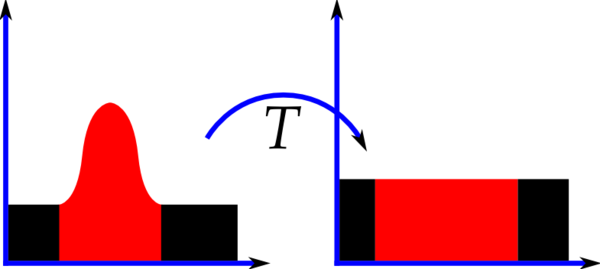**

In [ ]:
normalized_patient_100 = histogram_normalize_4d(rescaled_patient_100)

In [ ]:
plot_patient_slices_3d(normalized_patient_100[5])


### 3. Crop images aroind ROI 

Identified using Fourier Transform over time

In [ ]:
# This is set after experiments. Could be lowered for shorter runtime
heart_pixel_size = 150

Fourier transform calculating first harmonic mean

In [ ]:
ft_patient_100 = fourier_time_transform(normalized_patient_100)

In [ ]:
plot_patient_slices_3d(ft_patient_100)

In [ ]:
# Threshold for segmentation + erode for removing "noise" + mean coordinates for labels
# Segmentation is not necessary here? We can erode than just calculate mean coordinates for intensity. 
# This would yeild a better estimate of ROI because the higher intensity the higher movement.

y, x = roi_mean_yx(ft_patient_100)

In [ ]:
num_slices, time, h, w = normalized_patient_100.shape
heart_cropped_patient_100_4d = np.zeros((num_slices, time, heart_pixel_size, heart_pixel_size))

for i in range(num_slices):
        for j in range(time):
            heart_cropped_patient_100_4d[i,j] = crop_roi(normalized_patient_100[i,j], heart_pixel_size, heart_pixel_size, y, x)


In [ ]:
plot_patient_slices_3d(heart_cropped_patient_100_4d[5])

### 4. Rotate images 
Such that left ventricle is in top right part of img


In [ ]:
rotated_patient_100 = rotate_images_210_deg(heart_cropped_patient_100_4d, patient_100.orientation)

In [ ]:
plot_patient_slices_3d(rotated_patient_100[5])

### 5. Segment out left ventricle
For each 2d slice. Uses watershed (go up for implementation). 
Also tried Threshold, K-means and EM Segmentation with worse result.
EM segmentation took way to long time. 

K-means similar result but way longer time.

In [ ]:
segmented_left_ventricle_4d, labels = find_left_ventricle(rotated_patient_100,kmeans=False)

In [ ]:
kmeans_segmented_left_ventricle_4d, labels = find_left_ventricle(rotated_patient_100,kmeans=True)

Threshold Segmentation Plot

In [ ]:
plot_patient_slices_3d(segmented_left_ventricle_4d[5])

Kmeans Segmentation Plot

In [ ]:
plot_patient_slices_3d(kmeans_segmented_left_ventricle_4d[5])

### 6. Caluculating Volume
Since every 4d image is scaled 1:1 we sum upp all voxels for each timestep. Then we take max/min to calculate ejection rate.

In [ ]:
def volume_for_patient(patient_images, slice_dist):
    """
    Return numpy array
    Array of total volume at each time for segmented images
    """
    
    num_slices, time, height, width = patient_images.shape
    volume = np.zeros((time))
    
    if slice_dist == 0:
        print("WARNING! Slice ditance is: 0 \n Setting slice distance to 10.")
        slice_dist = 10
    
    for i in range(time):
        time_volume = 0
        for j in range(num_slices):
            xy_size = np.sum(patient_images[j,i])
            time_volume = time_volume + xy_size * slice_dist
            
        # Volume in ml instead of mm^3
        volume[i] = time_volume/1000
    
    return volume 

In [ ]:
v = volume_for_patient(segmented_left_ventricle_4d, patient_100.dist)

In [ ]:
plt.plot(v)

Just one bad segmentation ca lead to patient beeing miss diagnosed since max/min value where taken.

### Example with other patients

In [ ]:
patient_ex = load_patient(20)
rescaled_patient_ex = rescale_patient_4d_imgs(patient_ex)
normalized_patient_ex = histogram_normalize_4d(rescaled_patient_ex)
plot_patient_slices_3d(normalized_patient_ex[5])

In [ ]:
ft_patient_ex = fourier_time_transform(normalized_patient_ex)
y, x = roi_mean_yx(ft_patient_ex)

num_slices, time, h, w = normalized_patient_ex.shape
heart_cropped_patient_ex_4d = np.zeros((num_slices, time, heart_pixel_size, heart_pixel_size))

for i in range(num_slices):
        for j in range(time):
            heart_cropped_patient_ex_4d[i,j] = crop_roi(normalized_patient_ex[i,j], heart_pixel_size, heart_pixel_size, y, x)
            
rotated_patient_ex = rotate_images_210_deg(heart_cropped_patient_ex_4d, patient_ex.orientation)
segmented_left_ventricle_4d_ex, labels = find_left_ventricle(rotated_patient_ex,kmeans=False)
plot_patient_slices_3d(segmented_left_ventricle_4d_ex[5])

In [ ]:
patient_ex = load_patient(400)
rescaled_patient_ex = rescale_patient_4d_imgs(patient_ex)
normalized_patient_ex = histogram_normalize_4d(rescaled_patient_ex)
plot_patient_slices_3d(normalized_patient_ex[5])

In [ ]:
ft_patient_ex = fourier_time_transform(normalized_patient_ex)
y, x = roi_mean_yx(ft_patient_ex)

num_slices, time, h, w = normalized_patient_ex.shape
heart_cropped_patient_ex_4d = np.zeros((num_slices, time, heart_pixel_size, heart_pixel_size))

for i in range(num_slices):
        for j in range(time):
            heart_cropped_patient_ex_4d[i,j] = crop_roi(normalized_patient_ex[i,j], heart_pixel_size, heart_pixel_size, y, x)
            
rotated_patient_ex = rotate_images_210_deg(heart_cropped_patient_ex_4d, patient_ex.orientation)
segmented_left_ventricle_4d_ex, labels = find_left_ventricle(rotated_patient_ex,kmeans=False)
plot_patient_slices_3d(segmented_left_ventricle_4d_ex[5])